In [ ]:
# Danila Valko
# December 2023

### setup

In [1]:
base_dir = './ln-one-shot-path-planning/'

In [10]:
!rm -rf ln-one-shot-path-planning
!git clone https://github.com/ellariel/ln-one-shot-path-planning.git

Cloning into 'ln-one-shot-path-planning'...
remote: Enumerating objects: 178, done.
remote: Total 178 (delta 0), reused 0 (delta 0), pack-reused 178
Receiving objects: 100% (178/178), 318.81 MiB | 25.86 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [3]:
import networkx as nx
import random
import json, glob, math
import seaborn as sns
import numpy as np
from collections import OrderedDict
import os, sys, time, pickle, datetime, scipy
from tqdm import tqdm, notebook
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel
from scipy.stats import pearsonr, spearmanr
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import ScalarFormatter
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore")
sfmt = StrMethodFormatter('{x:,.2f}')
xfmt = ScalarFormatter(useMathText=True)
xfmt.set_powerlimits((0,0))

In [4]:
snapshots_dir = os.path.join(base_dir, 'snapshots')
weights_dir = os.path.join(base_dir, 'weights')
results_dir = os.path.join(base_dir, 'results')
os.makedirs(results_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)

In [37]:
def plot_training(results='*-env-16-randomized-50-*', skip_down=0, skip_up=28000, idx=[0, 1, 3], labels={'mean_reward': 'average reward',
                                                                                  'train_score': 'training score',
                                                                                  'test_score': 'test score',
                                                                                  'avg_pathlen': 'average path length',
                                                                                  }):
    def _plot(log_data, left_keys=['mean_reward'], right_keys=['train_score', 'test_score'], _right_keys=['avg_pathlen']):
      _plot.palette=list(mcolors.TABLEAU_COLORS.values())
      _plot.c = 0
      def draw(ax, keys, ylabel=False, xlabel=False, xlog=False, ylog=False):
          for e in env:
                data = log_data[log_data['version'] == e]
                for k in keys:
                  if 'mean_reward' in k and 'max_'+k in data and pd.notna(data['max_'+k]).all():
                        _data = []
                        for idx, d in data.iterrows():
                          epoch = d['epoch']
                          for i in d['mean_reward'][1:][:-1].split():
                            _data.append((epoch, float(i)))
                        data = pd.DataFrame(_data).rename(columns={0:'epoch', 1:k})
                  try:
                    sns.lineplot(ax=ax, data=data, x='epoch', y=k, label=labels[k], color=_plot.palette[_plot.c])#, errorbar='ci') f' {k}({e})'
                  except:
                    pass
                  _plot.c += 1
          if not ylabel:
            ax.set_ylabel('/'.join(keys))
          else:
            ax.set_ylabel(ylabel)
          if xlog:
            ax.set(xscale='log')
          if ylog:
            ax.set(yscale='log')
          if xlabel:
            ax.set_xlabel(xlabel)

      env = log_data['version'].drop_duplicates()
      fig = plt.figure(figsize=(12,10))
      axs = [fig.add_subplot(221)]
      draw(axs[0], left_keys, ylabel='average reward', xlabel='epochs')
      legend = [axs[0].get_legend_handles_labels()]
      axs[-1].get_legend().remove()
      if right_keys:
        axs += [axs[0].twinx()]
        draw(axs[-1], right_keys, ylabel='score' if 'score' in right_keys[0] else ', '.join(right_keys), xlabel='epochs')
        legend += [axs[-1].get_legend_handles_labels()]
        axs[-1].get_legend().remove()
      if _right_keys:
        axs += [axs[0].twinx()]
        axs[-1].spines.right.set_position(("axes", 1.15))
        draw(axs[-1], _right_keys, ylabel='path length' if 'len' in _right_keys[0] else ', '.join(_right_keys), xlabel='epochs')
        legend += [axs[-1].get_legend_handles_labels()]
        axs[-1].get_legend().remove()
      axs[-1].legend(loc='lower left',
                    handles=[j for i in legend for j in i[0]],
                    labels=[j for i in legend for j in i[1]])
      fig.tight_layout()
      plt.show()

    logs = sorted(glob.glob(os.path.join(os.path.join(base_dir, 'results'), f'{results}.log')))
    print(f'{results}: {len(logs)} logs detected')
    log_data = None
    for l in logs:
        try:
          r = pd.read_csv(l, sep=';', compression='zip')
          if r.iloc[0]['idx'] not in idx:
            continue
          r['time'] = r['time'].apply(lambda x: datetime.datetime.utcfromtimestamp(x))
          r.sort_values(by='time', inplace=True)
          r['epoch_'] = r['epoch']
          r['epoch'] = r.index + 1 - skip_down
          if len(r):
            log_data = pd.concat([log_data, r.iloc[skip_down:skip_up]], ignore_index=True)
          #print(f'log: {l}')
        except:
          #print(f'log error: {l}')
          pass
    _plot(log_data)

def filter_ok(results):
  def calc_ok(results):
    ok = []
    for k, v in results.items():
        if 'emissions' not in k:
          if len(ok) < len(v):
            ok += [True] * (len(v) - len(ok))
          ok = [i and j['ok'] for i, j in zip(ok, v)]
    return ok
  _results = results.copy()
  ok = calc_ok(_results)
  #print(f"{list(_results.keys())[0].split('-')[1]:<5} {np.sum(ok) / len(ok):.2f} - ok")
  for k, v in _results.items():
      if 'emissions' not in k:
        _results[k] = [j for i, j in zip(ok, v) if i]
  return _results

def calc_emissions(emissions, results):
    e = emissions.copy()
    e['total_runtime'] = np.sum([r['runtime'] for r in results])
    e['emissions_rate'] = e['emissions'] / e['duration']
    e['total_emissions'] = e['emissions_rate'] * e['total_runtime']
    e = e[['emissions_idx','duration','emissions','emissions_rate','total_runtime','total_emissions']]
    return e

def get_metrics(results='*16-randomized-*0-*', metrics=['runtime', 'dist', 'delay', 'feerate', 'feeratio', 'ok'], subset=3):
    files = glob.glob(os.path.join(os.path.join(base_dir, 'results'), f'{results}.pickle'))
    print(f'{len(files)} results detected')

    files = sorted(files, key=lambda x: int(x.split('-')[-2].split('.pickle')[0])+int(x.split('-')[-1].split('.pickle')[0]))
    subs = set([int(x.split('-')[-2].split('.pickle')[0]) for x in files])
    final_files = []
    for s in subs:
        final_files += [f for f in files if f'-{s}-' in f][:subset]
    #print(final_files)
    total_emissions = None
    total_results = {}
    #print(files)
    for f in final_files:
        with open(f, 'rb') as f:
          r = pickle.load(f)
          r = filter_ok(r)
          for k in r.keys():
            if 'emissions' in k:
              _k = k[:k.index('-emissions')]
              _r = r[_k]
              _e = calc_emissions(pd.DataFrame.from_dict(r[k]), _r)
              total_emissions = pd.concat([total_emissions, _e], ignore_index=True)
              total_results[_k] = {}
              for m in metrics:
                total_results[_k][m] = [i[m] for i in _r]
    return total_results, total_emissions

def plot_runtime(metrics, emissions):
    alg = set(emissions['emissions_idx'].apply(lambda x: x.split('-')[0]))
    subgraph = set(emissions['emissions_idx'].apply(lambda x: int(x.split('-')[1])))
    colors = {k : v for k, v in zip(sorted(alg), ['blue', 'orange', 'green', 'red', ])}
    fig = plt.figure(figsize=(10,6))
    i = 0
    for n in sorted(subgraph):
        i += 1
        ax = fig.add_subplot(230 + i)
        ax.set_xlim([2, 10])
        ax.set_ylim(bottom=1e-6)
        ax.set_ylim(top=0.01)
        for a in sorted(alg):
            r = [{'pathlen': d,
                  'runtime': r} for k, v in metrics.items() if f'{a}-{n}' in k
                            for d, r in zip(v['dist'], v['runtime']) if pd.notna(r) and r > 0]
            if len(r):
                  r = pd.DataFrame.from_dict(r)
                  with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=ConvergenceWarning)
                    sns.regplot(ax=ax, data=r, x='pathlen', y='runtime', label=a, truncate=False,
                      scatter_kws=dict(s=20, linewidth=0.3, facecolors='none', edgecolors=colors[a]),
                      line_kws=dict(color=colors[a]), order=1) #, robust=True)
        ax.set_title(f'L={n}')
        ax.set_ylabel('runtime')
        ax.set_xlabel('path length')
        ax.yaxis.set_major_formatter(xfmt)
        leg = ax.legend(loc='upper left')
        leg = {handle.get_label(): handle for handle in leg.legendHandles}
        for k, v in leg.items():
            leg[k].set_color(colors[k])
    fig.tight_layout()
    plt.show()

def plot_emissions(metrics, emissions):
    alg = set(emissions['emissions_idx'].apply(lambda x: x.split('-')[0]))
    _data = emissions.copy()
    _data['alg'] = _data['emissions_idx'].apply(lambda x: x.split('-')[0])
    _data['subgraph'] = _data['emissions_idx'].apply(lambda x: int(x.split('-')[1]))
    colors = {k : v for k, v in zip(sorted(set(_data['alg'])), ['blue', 'orange', 'green', 'red', ])}
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(235)
    for a in sorted(alg):
        with warnings.catch_warnings():
          warnings.simplefilter("ignore", category=ConvergenceWarning)
          sns.regplot(ax=ax, data=_data[_data['alg'] == a], x='subgraph', y='total_runtime', label=a,
                    scatter_kws=dict(s=20, linewidth=0.3, facecolors='none', edgecolors=colors[a]),
                    line_kws=dict(color=colors[a]), order=3) #robust=True,
    ax.yaxis.set_major_formatter(xfmt)
    ax.set_ylabel('total runtime')
    ax.set_xlabel('neighbourhood size (L)')
    leg = ax.legend(loc='upper left')
    leg = {handle.get_label(): handle for handle in leg.legendHandles}
    for k, v in leg.items():
        leg[k].set_color(colors[k])

    ax = fig.add_subplot(236)
    for a in sorted(alg):
        with warnings.catch_warnings():
          warnings.simplefilter("ignore", category=ConvergenceWarning)
          sns.regplot(ax=ax, data=_data[_data['alg'] == a], x='subgraph', y='total_emissions', label=a,
                    scatter_kws=dict(s=20, linewidth=0.3, facecolors='none', edgecolors=colors[a]),
                    line_kws=dict(color=colors[a]), order=3) #robust=True,
    ax.yaxis.set_major_formatter(xfmt)
    ax.set_ylabel('total emissions')
    ax.set_xlabel('neighbourhood size (L)')
    leg = ax.legend(loc='upper left')
    leg = {handle.get_label(): handle for handle in leg.legendHandles}
    for k, v in leg.items():
        leg[k].set_color(colors[k])

    fig.tight_layout()
    plt.show()

def plot_perfomance(metrics, ylim=0.5, color={'training': 'blue',
                                              'test': 'green'}):
    metric_list = ['delay', 'feerate']#, 'runtime', 'dist']#, 'delay', 'feerate']#, 'feeratio', 'ok']
    alg = ['RLA']
    _r = {}
    if not os.path.exists(os.path.join(results_dir, 'perf.json')):
      for key in metrics.keys():
        if 'RLA' in key:
          k = key.split('-')[1:]
          weights_file_list = glob.glob(os.path.join(weights_dir, f'*-{k[0]}-{k[1]}.sav-*'))
          if len(weights_file_list):
              weights_file_list = sorted(weights_file_list, key=lambda x: float(''.join([i for i in x.split('-')[-1] if i.isdigit() or i == '.'])))
              if os.path.exists(weights_file_list[-1]):
                  weights_file = weights_file_list[-1]
                  _r.update({key: weights_file.split('-')[-2:]})

      with open(os.path.join(results_dir, 'perf.json'), 'w') as outfile:
         json.dump(_r, outfile)
    with open(os.path.join(results_dir, 'perf.json'), 'r') as outfile:
         _r = json.load(outfile)

    fig = plt.figure(figsize=(6,5.5))
    i = 0
    for m in metric_list:
      i += 1
      ax = fig.add_subplot(220+i)
      ax.set_xlim([0.5, 1])
      d = None
      for _k in _r.keys():
          r = {a: [i for k, v in metrics.items() if _k in k for i in v[m]] for a in alg}
          if len(r):
            r = pd.DataFrame.from_dict(r)
            r['x_train'] = float(_r[_k][0])
            r['x_test'] = float(_r[_k][1])
            d = pd.concat([d, r[['RLA', 'x_train']].rename(columns={'x_train': 'score', 'RLA': 'training'}),
                              r[['RLA', 'x_test']].rename(columns={'x_test': 'score', 'RLA': 'test'})], ignore_index=True)
      d = d.set_index('score')
      for k in d.columns:
          ax.set_ylim(top=np.max(d[k])*ylim)
          sns.regplot(ax=ax, data=d[k].reset_index(), x='score', y=k, label=k, y_jitter=0.0001, x_jitter=0.0001, color=color[k], truncate=False,
                line_kws=dict(color=color[k],), order=1,
                scatter_kws=dict(s=35,
                                linewidth=0.3,
                                facecolors='none',
                                edgecolors='light'+color[k],
                                 ))
      ax.yaxis.set_major_formatter(xfmt)

      ax.set_ylabel(m)
      leg = ax.legend()
      leg = {handle.get_label(): handle for handle in leg.legendHandles}
      for k in d.columns:
        try:
          leg[k].set_color(color[k])
        except:
          pass
    fig.tight_layout()
    plt.show()

def plot_metrics():
    metric_list = ['runtime', 'dist', 'delay', 'feerate']#, 'feeratio', 'ok']
    alg = set(emissions['emissions_idx'].apply(lambda x: x.split('-')[0]))
    subgraph = set(emissions['emissions_idx'].apply(lambda x: int(x.split('-')[1])))
    for m in metric_list:
      fig = plt.figure(figsize=(10,6))
      i = 0
      for n in sorted(subgraph):
          i += 1
          ax = fig.add_subplot(230 + i)
          r = {a: [i for k, v in metrics.items() if f'{a}-{n}' in k for i in v[m]] for a in alg}
          if len(r):
                    r = pd.DataFrame.from_dict(r)
                    r = r[sorted(r.columns)]
                    sns.ecdfplot(ax=ax, data=r, legend=True, log_scale=m in ['runtime', 'feeratio', 'feerate'])
                    ax.set_xlabel(m)
                    ax.set_title(f'L={n}')
                    ax.yaxis.set_major_formatter(xfmt)
                    ax.legend(loc='lower right', labels=[f'{i[0]}, µ={i[1]:.2e}' for i in r.aggregate('mean').sort_index(ascending=False).items()])
      fig.tight_layout()

def plot_metrics_total():
    metric_list = ['runtime', 'dist', 'delay', 'feerate']#, 'feeratio', 'ok']
    alg = set(emissions['emissions_idx'].apply(lambda x: x.split('-')[0]))
    subgraph = set(emissions['emissions_idx'].apply(lambda x: int(x.split('-')[1])))
    fig = plt.figure(figsize=(6,6))
    i = 0
    for m in metric_list:
      d = None
      i += 1
      ax = fig.add_subplot(220+i)
      for n in sorted(subgraph):
          r = {a: [i for k, v in metrics.items() if f'{a}-{n}' in k for i in v[m]] for a in alg}
          if len(r):
            r = pd.DataFrame.from_dict(r)
            r = r[sorted(r.columns)]
            d = pd.concat([d, r], ignore_index=True)
      sns.ecdfplot(ax=ax, data=d, legend=True, log_scale=m in ['runtime', 'feeratio', 'feerate'])
      ax.set_xlabel(m)
      #ax.set_title(f'L={n}')
      ax.yaxis.set_major_formatter(xfmt)
      ax.legend(loc='lower right', labels=[f'{i[0]}, µ={i[1]:.1e}' for i in r.aggregate('mean').sort_index(ascending=False).items()])
      fig.tight_layout()

### runtime/emissions analysis

In [11]:
%%time
metrics, emissions = get_metrics()

24 results detected
CPU times: user 614 ms, sys: 6.16 ms, total: 620 ms
Wall time: 628 ms


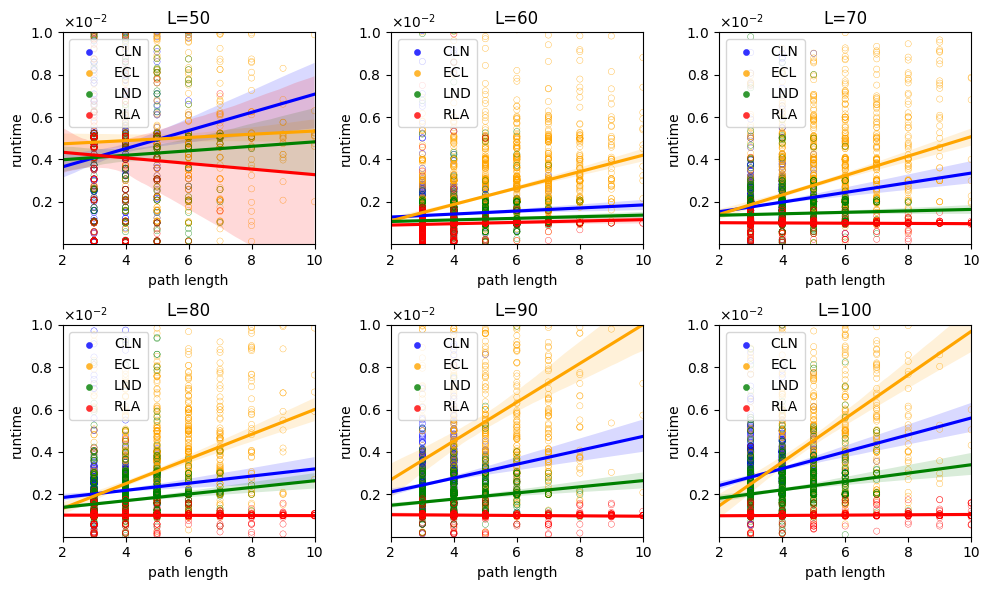

CPU times: user 4.37 s, sys: 178 ms, total: 4.55 s
Wall time: 4.37 s


In [38]:
%%time
plot_runtime(metrics, emissions)

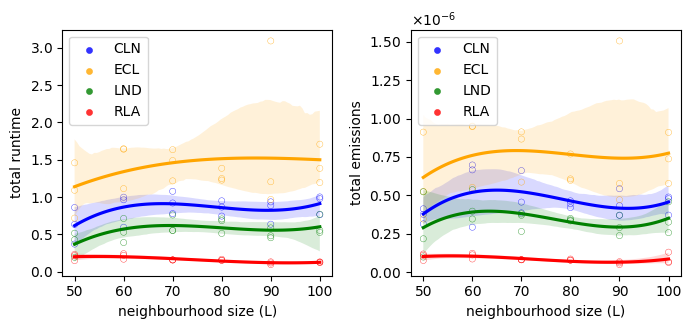

CPU times: user 1.6 s, sys: 151 ms, total: 1.76 s
Wall time: 1.64 s


In [27]:
%%time
plot_emissions(metrics, emissions)

### perfomance analysis

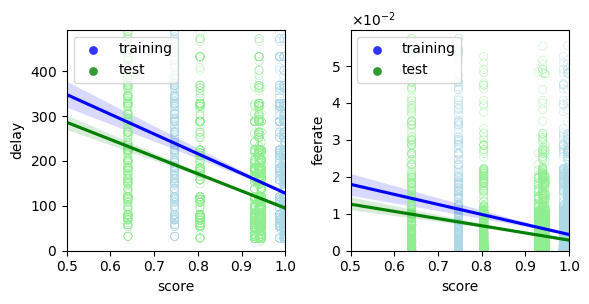

In [15]:
plot_perfomance(metrics)

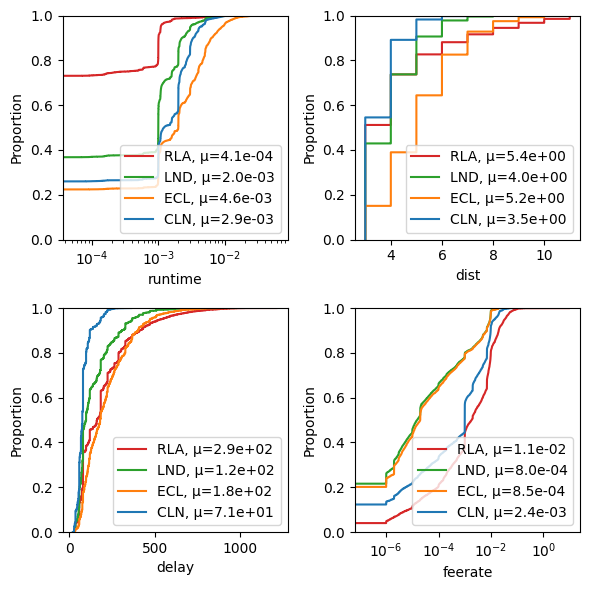

In [16]:
plot_metrics_total()

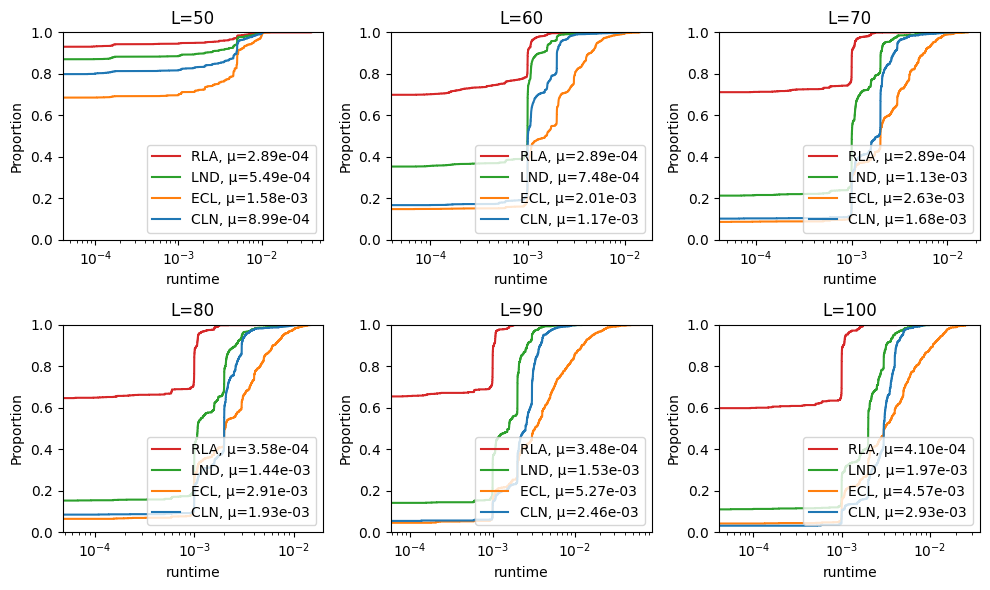

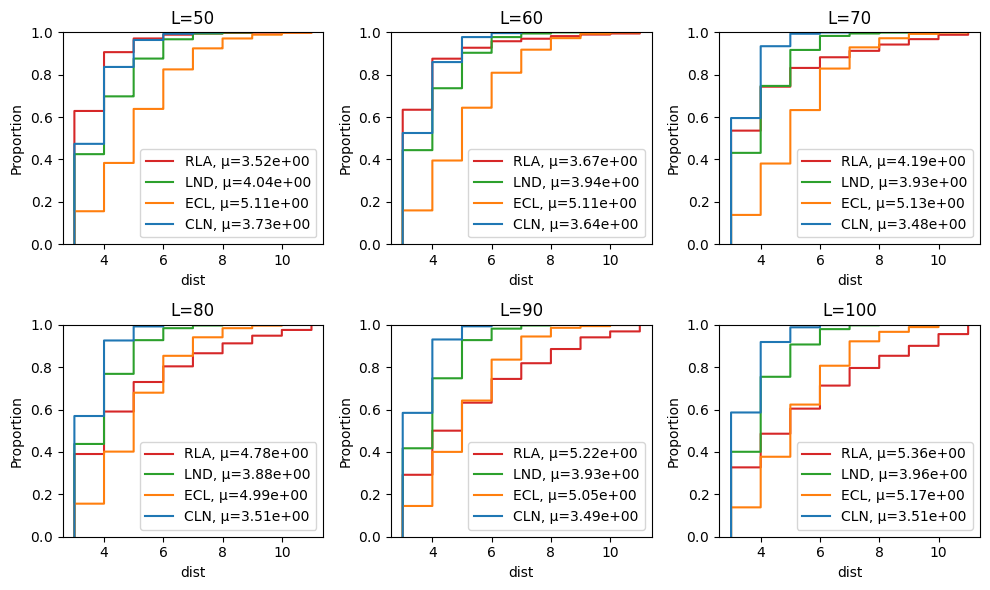

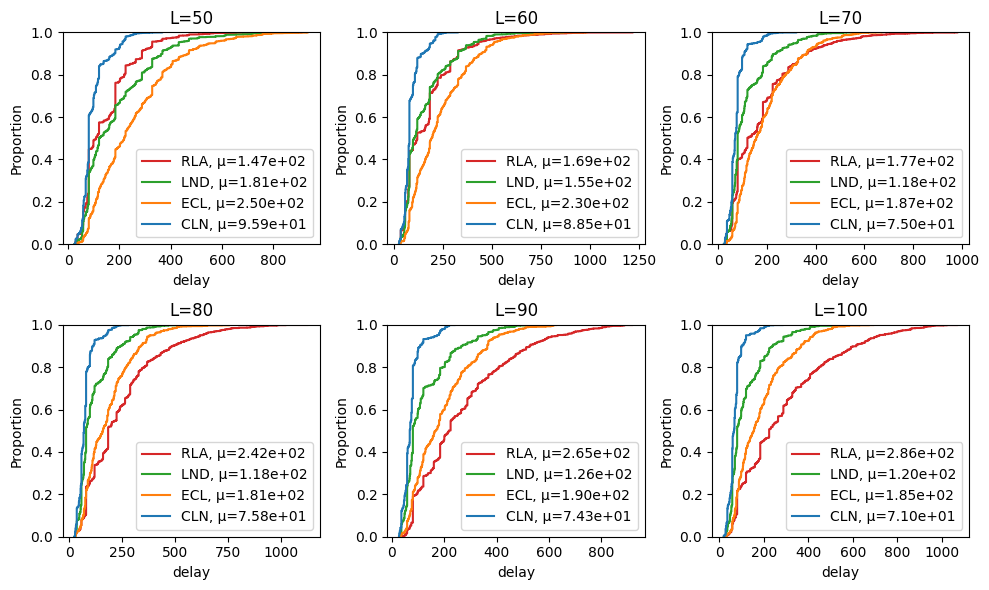

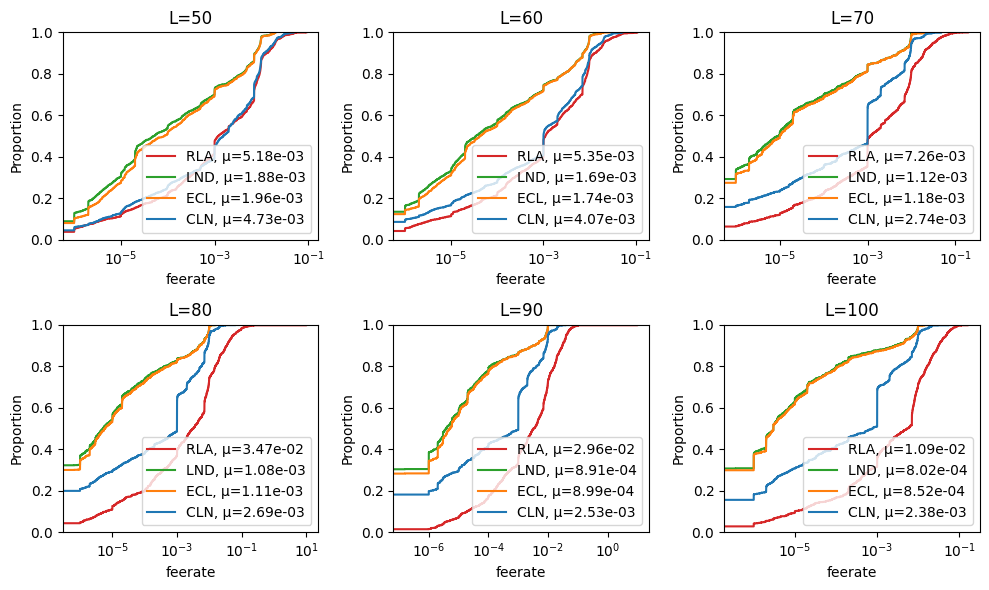

In [17]:
plot_metrics()

### training analysis

*-env-16-randomized-50-*: 4 logs detected


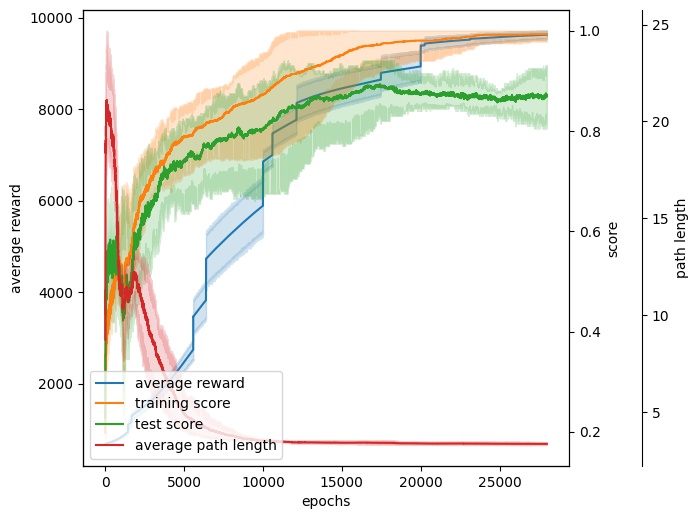

In [39]:
plot_training()